In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
from numpy import genfromtxt
import os
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("../../../")
from utils.utils import MyDataset, MyDatasetV2, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
from networks.vae import VAE
from networks.vae_v2 import VAE_V2
from networks.ccvae import CCVAE
from networks.utils import EarlyStopper
import argparse
from algorithms.GA.utils import write_firewall_file, erase_firebreaks
from tqdm import tqdm
from torchmetrics import Accuracy, Precision, Recall, F1Score, Dice
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score, MeanAbsolutePercentageError
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA


In [2]:
dataset = MyDataset("../../../../data/complete_random/homo_2/")
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.9, 0.05, 0.05], generator=torch.Generator().manual_seed(42))


In [3]:
params = {}
params["latent_dims"] = 256
params["capacity"] = 128
params["use_gpu"] =  False
params["input_size"] = 20
params["epochs"] = 20
params["sigmoid"] = True
params["lr1"] = 1e-5
params["lr2"] = 1e-5
params["instance"] = "homo_2"
params["not_reduced"] = False
params["variational_beta"] = 0.1
params["distribution_std"] = 0.1
params["latent_portion"] = 0.5
params["alpha"] = 10000

In [4]:
model = VAE(params).to("cpu")
model.eval()

VAE(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=6400, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=6400, out_features=256, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=6400, bias=True)
  (conv1_): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (criterion): BCELoss()
  (bn1_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1_2): Dropout(p=0.5, inplace=False)
)

In [5]:
# Load weights
model.load_state_dict(torch.load(f'../../../weights/homo_2/VAE/sub20x20_latent=256_capacity=1_100_sigmoid=True_T1=100_T2=100_lr1=1e-05_lr2=0.0001_lr3=0.0001_normalize=False_weight_decay=0_not_reduced=False_variational_beta=0.1_distribution_std=0.1.pth', map_location=torch.device('cpu') ))

<All keys matched successfully>

In [15]:
# Initialize metrics
accuracy = Accuracy(task="binary")
precision = Precision(task="binary")
recall = Recall(task="binary")
f1 = F1Score(task="binary")

In [17]:
for x, r in tqdm(validation_dataset):
    with torch.no_grad():
        x, r = torch.from_numpy(x), torch.from_numpy(r)
        recon = model(x.unsqueeze(0), r.unsqueeze(0))
        _, indices = torch.topk(recon.flatten(), 20)
        indices = np.unravel_index(indices, (20, 20))
        matrix = torch.zeros((20, 20))
        matrix[indices] = 1.
        # Update metrics
        accuracy.update(matrix, x[0])
        precision.update(matrix, x[0])
        recall.update(matrix, x[0])
# Compute final aggregated metrics
final_accuracy = accuracy.compute()
final_precision = precision.compute()
final_recall = recall.compute()


print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")

100%|██████████| 2500/2500 [00:11<00:00, 208.55it/s]

Accuracy: 0.9999
Precision: 0.9995
Recall: 0.9995


In [19]:
for x, r in tqdm(train_dataset):
    with torch.no_grad():
        x, r = torch.from_numpy(x), torch.from_numpy(r)
        recon = model(x.unsqueeze(0), r.unsqueeze(0))
        _, indices = torch.topk(recon.flatten(), 20)
        indices = np.unravel_index(indices, (20, 20))
        matrix = torch.zeros((20, 20))
        matrix[indices] = 1.
        # Update metrics
        accuracy.update(matrix, x[0])
        precision.update(matrix, x[0])
        recall.update(matrix, x[0])
# Compute final aggregated metrics
final_accuracy = accuracy.compute()
final_precision = precision.compute()
final_recall = recall.compute()


print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")

100%|██████████| 45000/45000 [02:59<00:00, 250.22it/s]

Accuracy: 0.9999
Precision: 0.9994
Recall: 0.9994


In [21]:
# Get embeddings from 10000 points in train_dataset into a numpy array
embeddings = []
r_ = []
for x, r in tqdm(train_dataset):
    with torch.no_grad():
        x, r = torch.from_numpy(x), torch.from_numpy(r)
        z, _ = model.encode(x.unsqueeze(0))
        embeddings.append(z[0].numpy())
        r_.append(r.item())
embeddings = np.array(embeddings)
r_ = np.array(r_)

100%|██████████| 45000/45000 [01:03<00:00, 703.85it/s]


/home/lu/.pyenv/versions/3.11.6/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


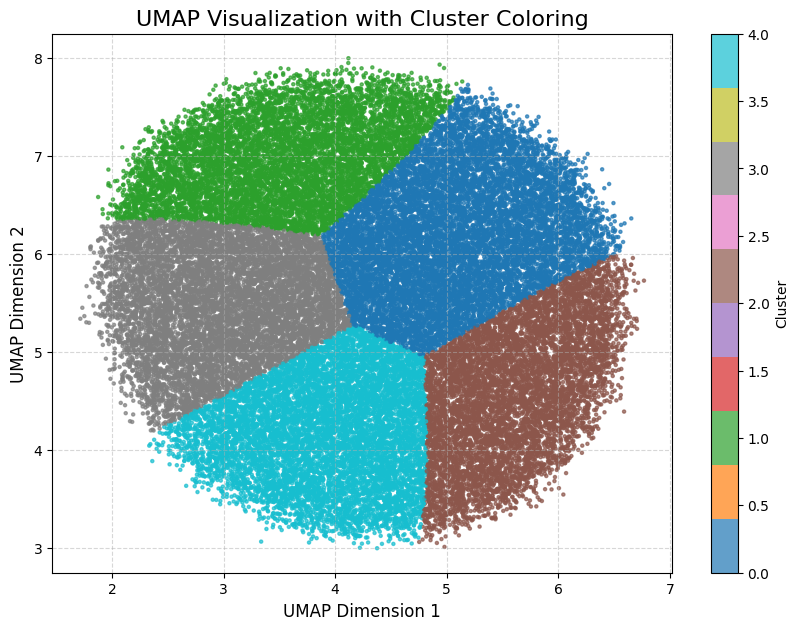

In [25]:
# Step 2: Apply UMAP
n = 50000
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, metric='cosine', random_state=42)
embeddings_2d = reducer.fit_transform(embeddings[:n])


# Step 2: Apply GMM
n_components = 5  # Number of clusters to identify
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(embeddings_2d)

# Step 4: Visualize with Colors
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gmm_labels, cmap='tab10', s=5, alpha=0.7)
plt.title('UMAP Visualization with Cluster Coloring', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter, label="Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


/home/lu/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


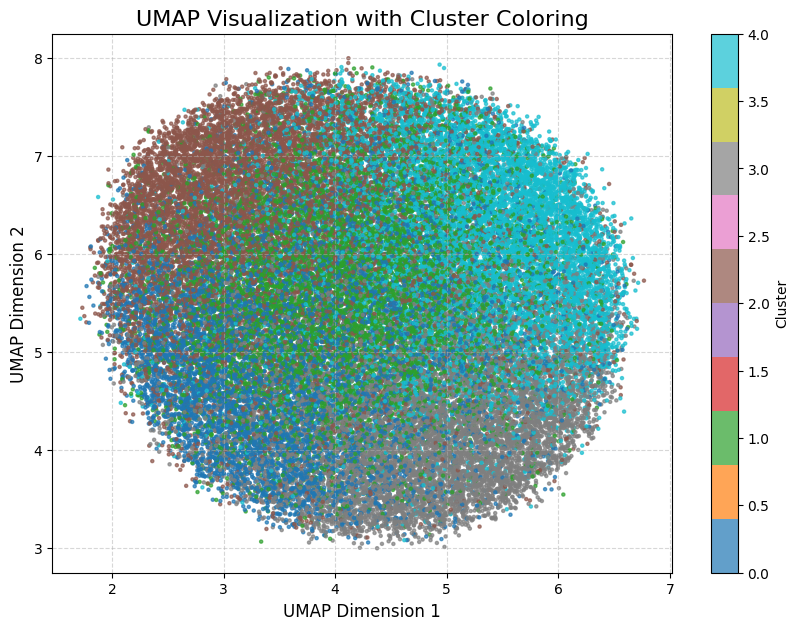

In [26]:
# Step 3: Apply Clustering (e.g., K-Means)
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings[:n])

# Step 4: Visualize with Colors
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', s=5, alpha=0.7)
plt.title('UMAP Visualization with Cluster Coloring', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter, label="Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

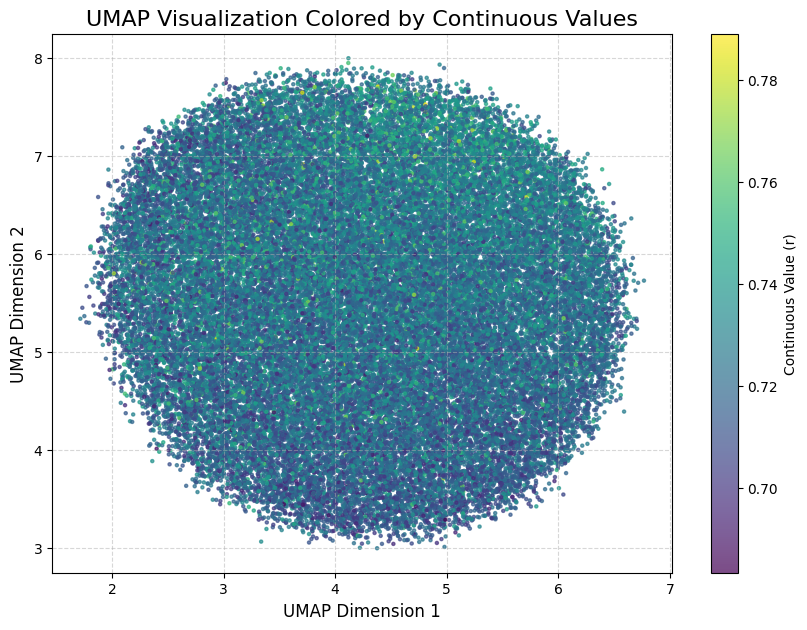

In [27]:
# Step 4: Visualize with Continuous Color Mapping
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], 
    c=r_[:n], cmap='viridis', s=5, alpha=0.7
)
plt.colorbar(scatter, label="Continuous Value (r)")  # Add colorbar for the scale
plt.title('UMAP Visualization Colored by Continuous Values', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [7]:
x, r = dataset[1]
recon = model(torch.from_numpy(x).unsqueeze(0), torch.from_numpy(r).unsqueeze(0)) 

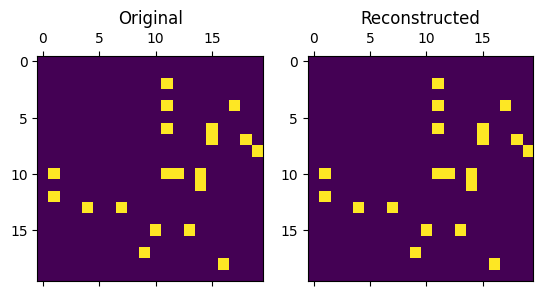

In [8]:
# Plotting the original binary matrix
plt.subplot(1, 2, 1)
plt.title('Original')
plt.matshow((x[0]), fignum=False)

# Plotting the reconstructed binary matrix
plt.subplot(1, 2, 2)
plt.title('Reconstructed')
plt.matshow((recon[0] >= 0.5)[0].int(), fignum=False)
plt.show()


In [87]:
burned_r = []
burned_real = []
for x, r in tqdm(validation_dataset):
    _, r_ = model(x.unsqueeze(0), r.unsqueeze(0))
    burned_real.append(r.item())
    burned_r.append(r_.item())

100%|██████████| 2500/2500 [00:11<00:00, 219.13it/s]


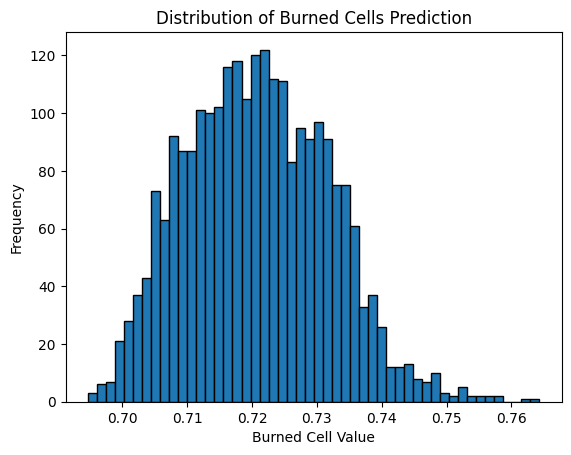

In [88]:
# plotting the distribution of burned_r
plt.hist(burned_r, bins=50, edgecolor='black')
plt.title('Distribution of Burned Cells Prediction')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.show()

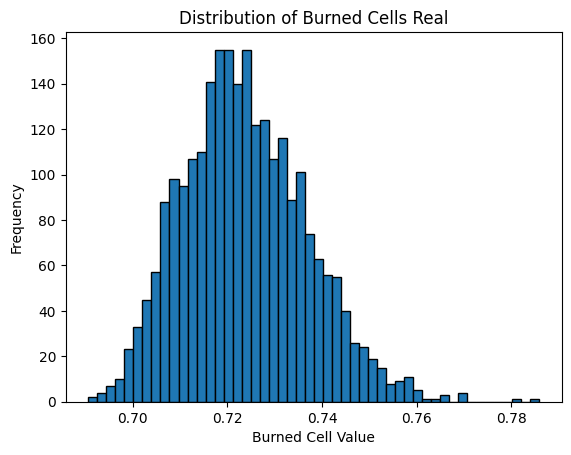

In [89]:
# plotting the distribution of burned_r
plt.hist(burned_real, bins=50, edgecolor='black')
plt.title('Distribution of Burned Cells Real')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.show()

In [112]:
model.training = False

In [28]:
x, r = dataset[2000]
mu, log_sigma = model.encode(x.unsqueeze(0))

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [115]:
sample = model.latent_sample(mu, log_sigma)

In [116]:
x, r_ = dataset[40000]
mu_, log_sigma_ = model.encode(x.unsqueeze(0))

In [117]:
alpha = 0.5
interp = alpha * mu + (1 - alpha) * mu_

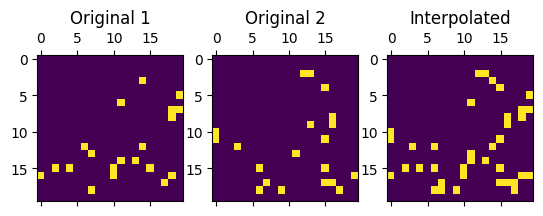

In [118]:
# Plot the original image and the sampled image and interp
plt.subplot(1, 3, 1)
plt.title('Original 1')
plt.matshow((x[0] > 0).int(), fignum=False)

plt.subplot(1, 3, 2)
plt.title('Original 2')
plt.matshow(model.decode(sample)[0][0] >= 0.5, fignum=False)

plt.subplot(1, 3, 3)
plt.title('Interpolated')
plt.matshow(model.decode(interp)[0][0] >= 0.5, fignum=False)

plt.show()


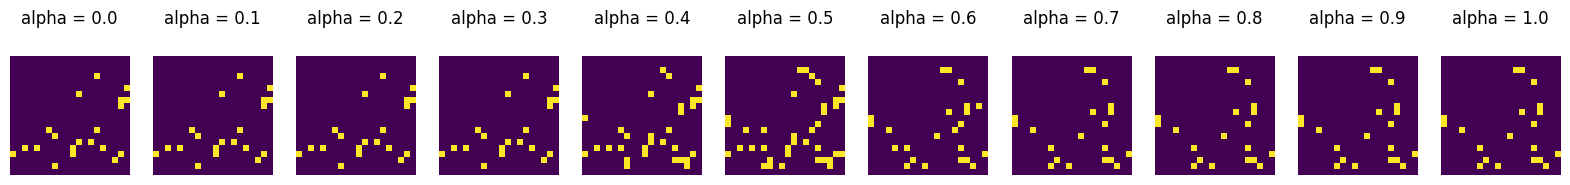

In [119]:
# Create a figure with 11 subplots with different values of alpha from 0 to one
fig, axs = plt.subplots(1, 11, figsize=(20, 2))

for i, ax in enumerate(axs):
    alpha = i / 10
    interp = alpha * mu + (1 - alpha) * mu_
    ax.matshow(model.decode(interp)[0][0] >= 0.5)
    ax.axis('off')
    ax.set_title(f'alpha = {alpha}')



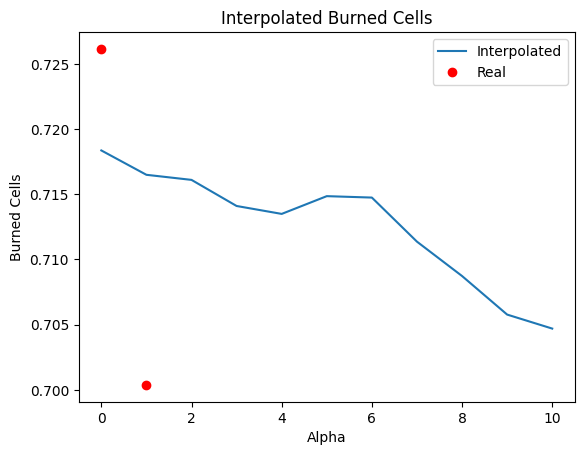

In [120]:
# Now plot the progression from alpha = 0 to alpha = 1, considering the second output of the decoder
per = []
for i in range(11):
    alpha = i / 10
    interp = alpha * mu + (1 - alpha) * mu_
    a = model.predict_burned(interp)
    per.append(a.item())

# plot the list per and the real values r and r_ with start and end points
plt.plot(per, label='Interpolated')
plt.plot([r_.item(), r.item()], 'ro', label='Real')
plt.legend()
plt.title('Interpolated Burned Cells')
plt.xlabel('Alpha')
plt.ylabel('Burned Cells')
plt.show()

In [ ]:
def calc_fitness(model, embedding, n_sims = 50):
        """
        Calculates the average number of burned cells of embedding's associated
        solution.
        """
        solution = model.decode(embedding[0])
        _, indices = torch.topk(solution.flatten(), 20)
        indices = np.unravel_index(indices, (20, 20))
        matrix = torch.zeros((20, 20))
        matrix[indices] = 1.
        assert(matrix.sum().item() == 20)
        write_firewall_file(matrix * -1.)
        n_weathers = len([i for i in os.listdir("../../../../data/complete_random/homo_2/Sub20x20/Weathers/") if i.endswith('.csv')])-2
        exec_str = f"../../../algorithms/eval/C2F-W/Cell2Fire/Cell2Fire --input-instance-folder ../../../../data/complete_random/homo_2/Sub20x20/ --output-folder ../../../algorithms/eval/results/ --sim-years 1 --nsims {n_sims}--Fire-Period-Length 1.0 --output-messages --ROS-CV 0.0 --seed 123 --weather random --ignitions --IgnitionRad 4 --sim C --final-grid --nweathers {n_weathers} --FirebreakCells ../../../algorithms/eval/harvested/HarvestedCells.csv"
        os.system(exec_str + " >/dev/null 2>&1")
        reward = 0
        base_directory = f"../../../algorithms/eval/results/Grids/Grids"
        for j in range(1, n_sims+1):
            dir = f"{base_directory}{str(j)}/"
            files = os.listdir(dir)
            my_data = genfromtxt(dir+files[-1], delimiter=',')
            # Burned cells are counted and turned into negative rewards
            for cell in my_data.flatten():
                if cell == 1:
                    reward-= 1
        erase_firebreaks()
        return 1 + ((reward/n_sims) / 400)

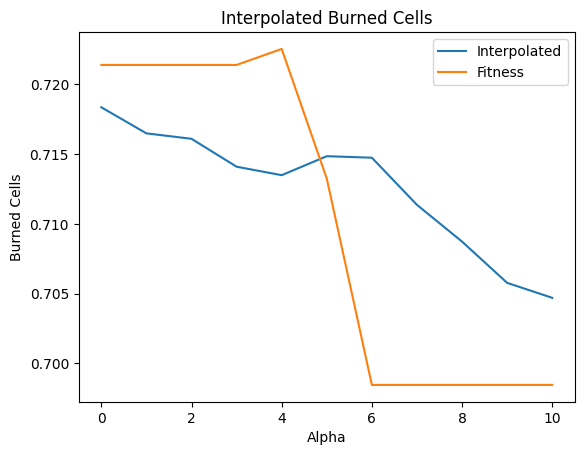

In [122]:
# Now plot the progression from alpha = 0 to alpha = 1, considering the second output of the decoder
per = []
values = []
for i in range(11):
    alpha = i / 10
    interp = alpha * mu + (1 - alpha) * mu_
    a = model.predict_burned(interp)
    sol = model.decode(interp)
    fitness = calc_fitness(model, interp.unsqueeze(0))
    values.append(fitness)
    per.append(a.item())

# plot the list per and the real values r and r_ with start and end points
plt.plot(per, label='Interpolated')
plt.plot(values, label='Fitness')
plt.legend()
plt.title('Interpolated Burned Cells')
plt.xlabel('Alpha')
plt.ylabel('Burned Cells')
plt.show()